# Mod 3 Final Project

* Student name: Ryan Beck
* Student pace: part time
* Scheduled project review date/time: Nov 18th, 5pm EST
* Instructor name: Abhineet Kulkarni
* Presentation: https://docs.google.com/presentation/d/1HJ75oss1jd6dd66U6faFUXYBSNP4DqNiYU9N7DITTYk/edit?usp=sharing

**Project Overview:** In this project we are going to work with the Northwind database to identify and an answer four business driven questions that can be addressed with various hypothesis tests. First we'll set up our working environment and take an initial look at the data, then we'll dive in and work through a series of questions, with a primary focus on the use of discount rates and their effects on sales. 

Project Outline: 
1. Setup environment and do initial data inspection
2. Business case and initial questions
3. Question 1
    * State question
    * Gather and inspect data
    * Form hypothesis
    * Test hypothesis
    * State conclusions
4. Repeat for questions 2, 3, and 4

## Setting up our environment

### The Northwind Database Scehma: 

<img src="files/Northwind_ERD_updated.png">

#### Import Libraries
We'll need a number of different libraries to query our database, process data, do statistical analysis, and visualize our results. Also, there are number of things we'll do many times, so I've defined functions in another file and imported them to keep our notebook as clean as possible. 

In [33]:
# import libraries necessary to do analysis
import pandas as pd
import sqlite3
import numpy as np
from functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
sns.set_style('darkgrid')
%matplotlib inline

#### Initial Data Inspection

Let's take a look at what tables we have in our database and look at a few we might work with in our analysis. 

In [2]:
# connect to the database
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
# list the all tables in the database
cursor.execute('select name from sqlite_master where type ="table"').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

Our analysis will focus on discount usage, to do that we may want a closer look at the Order, OrderDetail, Employee, and Product tables to begin with. 

In [4]:
# query the database and create a pandas dataframe
OrderDetail = get_table(table='OrderDetail')
OrderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [5]:
# query the database and create a pandas dataframe
Employee = get_table(table='Employee')
Employee.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [6]:
# query the database and create a pandas dataframe
Product = get_table(table='Product')
Product.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


We'll have to do a direct SQL query of the 'Order' table because the format of the name

In [7]:
# query the database and create a pandas dataframe
cur.execute("""SELECT *
               FROM 'Order' """)

Order = pd.DataFrame(cur.fetchall())
Order.columns = [x[0] for x in cur.description]

Order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


## Business Case and Questions

Maximizing value per transaction is an essential element of success for a product driven business. It is essential that pricing is consistent, and that if discounts are used that they are used judiciously. This case will analyze the use of discounts and assess the level to which they are a useful tool for supporting sales. We'll ask:

1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
2. Do different employees sell a statistically significantly different quantity of items per order? If so, which ones?
3. Do different employees use discounts at a rate that is statistically significantly different than the overall average rate of discount use? If so, which employees are more likely to use a discount? Do those employees make more sales?
4. Do discounts have a statistically significant positive effect on revenue per sale? If so at which rates, and do employees that use discounts more frequently bring in statistically significantly more revenue?  

## Question 1

**Research question 1:** Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

#### Gather and inspect data for question 1

To answer this question we can work with data from the 'OrderDetail' table. 

In [8]:
# create dataframe to use for question 1 analysis
df = get_table(table='OrderDetail')

In [9]:
# Look at the structure of the data, the data types and counts, and central tendencies 
inspect_dataframe(df)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


None

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


From inspecting the data we know: 
* there are 2155 order details to analyze, with no null values
* there is a large range of unit prices and quantities
* There appear to be more sales with no discount than with one

Let's look more specifically at the values for discount

In [10]:
# Count the number of times each value in the Dicount column occurs
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

**Observations:**
* The largest number of sales have no discount at all (1317). 
* Discounts at 5, 10, 15, 20, and 25% all have similar counts
* All other rates have too small a count to be considered individually - we'll note that for later

In [11]:
# create a set of unique values from the Discount column
discount_rates = set(df.Discount.values)

In [12]:
# create a dictionary and populate it with each discount rate and the average quantity sold at that rate
avg_discount_order_size = {}

for d in discount_rates: 
    avg_discount_order_size[d] = df[df['Discount'] == d]['Quantity'].mean()
    
avg_discount_order_size

{0.0: 21.715261958997722,
 0.25: 28.24025974025974,
 0.2: 27.024844720496894,
 0.05: 28.01081081081081,
 0.15: 28.38216560509554,
 0.1: 25.23699421965318,
 0.03: 1.6666666666666667,
 0.06: 2.0,
 0.01: 2.0,
 0.04: 1.0,
 0.02: 2.0}

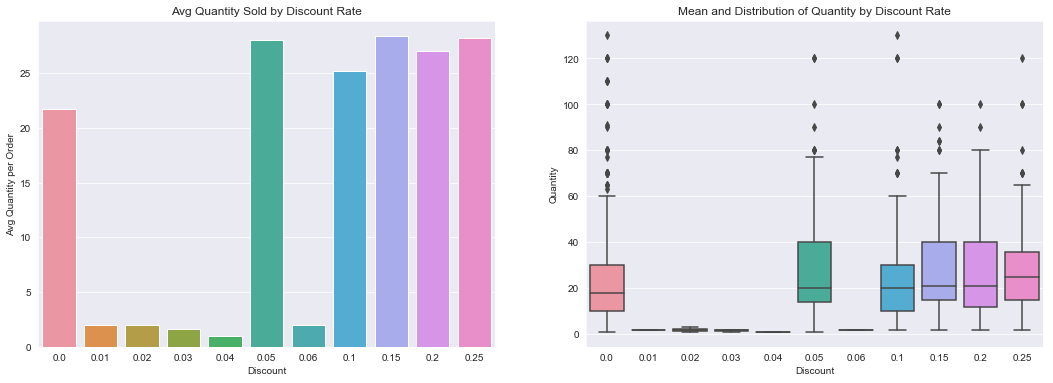

In [16]:
# set figure size and axes for two side-by-side plots
plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

# plot the average quantity sold at each level of discount
a = sns.barplot(x=list(avg_discount_order_size.keys()), y=list(avg_discount_order_size.values()), ax=ax1)
a.axes.set_title('Avg Quantity Sold by Discount Rate')
a.axes.set_xlabel('Discount')
a.axes.set_ylabel('Avg Quantity per Order')

# plot the mean and distribution of quantity sold at each discount level
b = sns.boxplot(x=df.Discount, y=df.Quantity, data=df, ax=ax2)
b.axes.set_title('Mean and Distribution of Quantity by Discount Rate')

plt.show()

**Observations:**
* Average quantity sold at many discount levels appear to be above the average quantity with no discount
* However the there do appear to be a number of outliers with larger quantities sold with no discount in the 0.0 discount category
* A number of the discount levels appear to have a too few examples to analyze them individually, we'll note that for later

In order to satisfy the first part of our question _Does discount amount have a statistically significant effect on the quantity of a product in an order?_ - we can break our data into two separate groups, the no-discount group (which will serve as our control), and the discount group, and we'll test to see if these two groups have a statistically significant effect.

In [17]:
# create two series of data - one which returns quantities where discount is 0.0
# and one which returns quantities are not equal to 0.0
no_d = np.array(df[df['Discount'] == 0.0]['Quantity'])
d = np.array(df[df['Discount'] != 0.0]['Quantity'])

In [18]:
# compare the size, mean, and std of both groups
compare_2(no_d,d)

The size of group1 is: 1317  	  The size of group2 is 838
The mean of group1 is: 21.715261958997722 	  The mean of group2 is: 27.10978520286396
The std of group1 is: 17.500845477669806 	  The std of group2 is: 20.759042075141373


**Observations:**
* The size of the no discount group is almost 500 larger than the discount group
* The mean and standard deviation of the discount group is larger than the mean of the no discount group
* This means that although the average quantity of discounts in the discount group is bigger, the range may be wider

Let's take a look at the distributions of the two groups visually in a distribution plot and compare

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


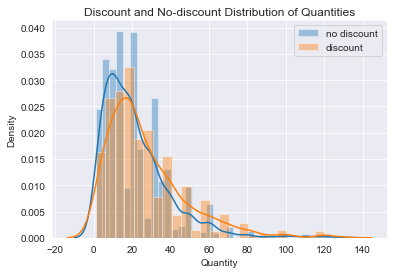

In [22]:
# plot two distribution plots together to compare
sns.distplot(no_d, label='no discount')
sns.distplot(d, label='discount')
plt.legend()
plt.title('Discount and No-discount Distribution of Quantities')
plt.xlabel('Quantity')
plt.ylabel('Density');

It looks like our data may not be very normally distributed, so we may want to work with it some before doing our hypothesis tests, but at this time we know enough to state our hypotheses. Based on what we've observed, it appears that there might be some positive relationship between discount and quantity sold, but it is hard to tell. Therefore we will state our hypotheses as: 

**Null Hypothesis (H0): There is no relationship between discount and quantity ordered**

**Alternative Hypothesis (Ha): There is a positive relationship between discount and quantity ordered - a discount is likely to result in a larger order**

To ensure we have a statistically significant effect we'll go for a 95% level of confidence, and set **alpha to .05**

In [23]:
# set alpha
alpha=.05

In order to accept or reject H0 we will conduct a statistical test to see if the quantities ordered with a discount are statistically significantly greater than our control group of orders, or, orders with no discount. 

We can test our hypothesis with a one-sided t-test. Both of our groups of data are independent of one another, that is to say that quantity ordered per order in one group should not be affected by quantity ordered in the other. Therefore we will do an independent t-test with. 

But, first we must check our assumptions of normality for each group to determine if we need to sample. We'll do this with the shapiro-wilke test for normality. 

In [24]:
# run the shapiro-wilkes test on both sets of data
test_normality(d)
test_normality(no_d)

p = 6.88120409395894e-26 	 Therefore the data is not normal
p = 3.803856556577728e-34 	 Therefore the data is not normal


False

It looks like our data are not normally distributed. We'll need to sample from them to see if we can arrive at a more normal distribution to run our tests on. Let's draw those samples and test for normality again. 

We will be using the bootstrap method of sampling. Bootstrapping is a type of resampling where large numbers of smaller samples of the same size are repeatedly drawn, with replacement, from a single original sample.

The function we've developed to do this will pull a random selection of 30 values from the original series, with replacement, find a mean, and append that mean to our list of samples. The function with do this as many times as it is told do, but the default is 30. 

In [25]:
# draw a random sample and create 30 means from our series of data
no_discount_sample = random_sample(no_d)
discount_sample = random_sample(d)

# run the shapiro-wilks test for normality on both lists
test_normality(no_discount_sample)
test_normality(discount_sample)

p = 0.6408089399337769 	 Therefore the data is normal
p = 0.2473510354757309 	 Therefore the data is normal


True

Awesome, it looks like the Central Limit Theorem wins again! By drawing a series of random samples and obtaining their means we have identified a more normally distributed set of data. We can now move forward and check our variance assumption next, but first let's get a quick visual representation of our data now.   

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


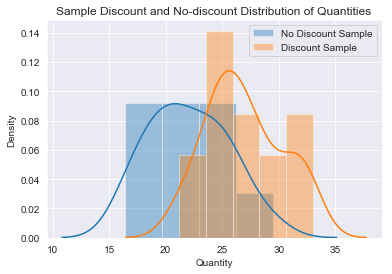

In [26]:
# plot two distribution plots together to compare
sns.distplot(no_discount_sample, label='No Discount Sample')
sns.distplot(discount_sample, label='Discount Sample')
plt.legend()
plt.title('Sample Discount and No-discount Distribution of Quantities')
plt.xlabel('Quantity')
plt.ylabel('Density');


Now let's check to see if we have equal variance among our sample groups, that will determine which type of t-test we should perform. We'll do this using Levene's test for equal variance. 

In [27]:
# test variance between two samples using Levene's test
test_variance(no_discount_sample, discount_sample)

p = 0.6660090956147875 	 Therefore the data has equal variances


True

Our samples have sufficiently equal variance, we'll therefore use the Student's T-Test for two independent samples to compare the two groups. We'll be looking for a p-value of less than .05 if we want to reject our null hypothesis.

#### Conduct statistical test

In [28]:
# run a independent t-test with equal varance to determine p
p = stats.ttest_ind(no_discount_sample, discount_sample, axis=0, equal_var=True)[1]

# compare the p-value with alpha
check_null_hypothesis(p,alpha=alpha)

With a p-value of 5.957026443661653e-07, which is less than 0.05 we can reject the H0 and accept Ha


False

It appears that for now we can **reject the null hypothesis** and conclude that there is a statistically significant and positive difference between quantities ordered with a discount than without a discount. There is a **very low probability of a type 1 error**, meaning that our results are due to random chance and that there is in fact not a positive effect on order size with a discount. 

In order to ensure that our results are as accurate as possible we can check the effect and power of our conclusions.

#### Check effect size

Effect size is used to quantify the size of the difference between two groups under observation. A large effect size, which we would hope to see to support the significance of our conclusions, would be **> .8**

In [29]:
# check effect size with cohen's d
discount_effect = cohen_d(no_discount_sample, discount_sample)
discount_effect

1.4729681140818658

This is a fairly large effect size, reinforcing our conclusion to reject H0. We can use effect size to check the statistical power of our results as well. Here we will be looking for a power larger than .8, which tells us that our number of observations were large enough to draw our conclusions at this level of alpha. 

#### Check statistical power

In [31]:
# set a variable to call TTestIndPower 
power = TTestIndPower()

In [32]:
# enter our effect size, number of observations, and alpha
# and set the solver to 'larger' to determine power level
power.solve_power(effect_size=discount_effect, nobs1=len(discount_sample), alpha=alpha, alternative='larger')

0.9999999941753608

We have the power! It looks like our sample size is sufficiently big enough to detect an effect given our degree of confidence as set by alpha. 

With this, we can again **affirm our conclusion to reject H0** and determine **claim that discount amount has a large statistically significant effect on quantity of product ordered.** 

We can now move on to answering the second part of our question, **which discount rates in fact have and effect on quantities ordered?** First we can check to see if there is a significant difference among rates by conducting an ANOVA analysis. 

#### Conduct ANOVA

An ANOVA will tell us where or not there is a significant difference among values on our target metric. As this is a statistical test we will need hypotheses for this as well: 

**Null Hypotheses (H0): There is no statistically significant difference between different discount rates and their effect on quantity ordered**

**Alternate Hypothesis(Ha): There is a statistically significant difference between the quantities ordered at different discount rates.**

In [34]:
# create formula with a target variable 'Quantity' and comparison variable
# 'Discount' is a categorical variable so we will place it in parentheses with 'C'
formula = 'Quantity ~ C(Discount)'

#fit the formula to a line by passing in the formula and target data 
lm = ols(formula, df).fit()
# create an ANOVA table and observe results
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Discount),21258.403604,10.0,6.011811,4.704231e-09
Residual,758141.232591,2144.0,NaN,NaN


With a very low p-value (4.7 e-09) we can conclude that there is in fact a difference among discount rates. Let's check the levels of significance for each category of discount. 

It appears that for now we can **reject H0** and accept the alternate hypotheses that **there is a statistically significant difference between the effects of different discount rates on quantity.**

Yet, it is difficult to determine from ANOVA alone which rates then have an effect, or even a significant one. We will require further analysis to answer our question.

In [35]:
# observe p-values for each discount rate
lm.pvalues

Intercept              6.746766e-281
C(Discount)[T.0.01]     2.947414e-01
C(Discount)[T.0.02]     1.385988e-01
C(Discount)[T.0.03]     6.524250e-02
C(Discount)[T.0.04]     2.709368e-01
C(Discount)[T.0.05]     2.095341e-05
C(Discount)[T.0.06]     2.947414e-01
C(Discount)[T.0.1]      2.065861e-02
C(Discount)[T.0.15]     2.789428e-05
C(Discount)[T.0.2]      7.326710e-04
C(Discount)[T.0.25]     4.781032e-05
dtype: float64

Recalling from our earlier value counts that there were very few observations for rates from 0.01-0.04, and only one for 0.06, we can disregard those as we do not have a large enough sample to determine statistical significance.

That leaves us with .05, .1, .15, .2 and .25. each of which appear to have a low enough p-value to suggest further analysis. 

To do this we will do **post hoc t-tests with the Bonferroni correction** to avoid the multiple comparisons problem. We will sample each group as before and compare them to the control sample (no discount). 

First, lets establish our new level of alpha by applying Bonferroni. 

#### Bonferroni Correction 

In [36]:
# set a new level of alpha by applying the Bonferroni correction
# enter the number of observations and original level of alpha
b_alpha = bonferroni_alpha(obs=5, alpha=alpha)
b_alpha

0.01

**Create samples:** Now we will need to create sample for each of our discount levels and test for normality and variance

In [37]:
# create a random sample using the bootstrap method for each level of discount
five_sample = random_sample(df[df['Discount'] == .05]['Quantity'])
ten_sample = random_sample(df[df['Discount'] == .1]['Quantity'])
fifteen_sample = random_sample(df[df['Discount'] == .15]['Quantity'])
twenty_sample = random_sample(df[df['Discount'] == .2]['Quantity'])
twentyfive_sample = random_sample(df[df['Discount'] == .25]['Quantity'])

# create a dictionary of samples to iterate through for easier analysis
discount_samples = {'5% Discount':five_sample, 
                    '10% Discount':ten_sample, 
                    '15% Discount':fifteen_sample, 
                    '20% Discount':twenty_sample, 
                    '25% Discount':twentyfive_sample}

# test the normality and compare variance for each discount sample and print results
for s in discount_samples:
    print(f'{s}: {test_normality(discount_samples[s])}')
    print(f'{s}: {test_variance(discount_samples[s], no_discount_sample)}\n')

p = 0.4486519396305084 	 Therefore the data is normal
5% Discount: True
p = 0.4036242476717694 	 Therefore the data has equal variances
5% Discount: True

p = 0.6951088309288025 	 Therefore the data is normal
10% Discount: True
p = 0.6389432564127812 	 Therefore the data has equal variances
10% Discount: True

p = 0.07728512585163116 	 Therefore the data is normal
15% Discount: True
p = 0.7253289430012282 	 Therefore the data has equal variances
15% Discount: True

p = 0.8032405376434326 	 Therefore the data is normal
20% Discount: True
p = 0.6549862269752373 	 Therefore the data has equal variances
20% Discount: True

p = 0.45204922556877136 	 Therefore the data is normal
25% Discount: True
p = 0.3588336784877766 	 Therefore the data has equal variances
25% Discount: True



By sampling for each discount level we've satisfied our normality and variance assumptions, now we can conduct t-tests with our new confidence level set by the Bonferroni Correction, and check for effect sizes and power levels as well. 

#### Conduct statistical tests

Our hypotheses for these tests (at each level of discount) will be: 

**Null Hypothesis (H0): The is no statistically significant effect on quantity ordered with discount rate X**

**Alternate Hypothesis (Ha): There is a statistically significant effect on quantity ordered with a discount of rate X** 

In [40]:
# find p-value and conduct a t-test with two independent samples and equal variance for each sample
for s in discount_samples:
    p = stats.ttest_ind(no_discount_sample, discount_samples[s], axis=0, equal_var=True)[1]
    print(f'{s}: {check_null_hypothesis(p, alpha=b_alpha)}\n')

With a p-value of 1.5774380789439364e-08, which is less than 0.01 we can reject the H0 and accept Ha
5% Discount: False

With a p-value of 0.0003767970221806813, which is less than 0.01 we can reject the H0 and accept Ha
10% Discount: False

With a p-value of 6.694527024007138e-09, which is less than 0.01 we can reject the H0 and accept Ha
15% Discount: False

With a p-value of 2.6516254076818564e-07, which is less than 0.01 we can reject the H0 and accept Ha
20% Discount: False

With a p-value of 4.5578149030004946e-11, which is less than 0.01 we can reject the H0 and accept Ha
25% Discount: False



It appears that accounting for the Bonferroni Correction we still have sufficiently low p-values to allow us to **reject H0** at each level of discount with a **very low probability of type 1 error**, and **accept Ha** and claim that these levels of discount have a **statistically significant effect on quantity**.  

We again want to check effect and power to determine the robustness of our results. 

#### Check effect at each discount level 

In [41]:
# determine effect size at each for each dicount rate and store in 
# a dictionary for easy further analysis
effect = {}
for s in discount_samples:
    effect[s] = cohen_d(no_discount_sample,discount_samples[s])
effect

{'5% Discount': 1.7237395709466992,
 '10% Discount': 0.991746268360515,
 '15% Discount': 1.7821475083676181,
 '20% Discount': 1.5295152079786414,
 '25% Discount': 2.1210180812093298}

**Observations:**
* Each discount rate has a large effect on quantity ordered
* 25% has the largest effect on quantity ordered - these seems intuitive since it is the largest discount
* 10% has the smallest effect - this is less intuitive as it is the second smallest discount
* There does not appear to be a direct relationship between size of discount and effect on quantity

As before, we also want to determine the statistical power of our results to ensure we have observed enough data to strongly support our conclusions

#### Check statistical power

In [42]:
# check power for each effect size
for e in effect: 
    print(f'{e}: {power.solve_power(effect_size=effect[e], nobs1=30, alpha=b_alpha)}')

5% Discount: 0.9999526620082115
10% Discount: 0.8758495261455246
15% Discount: 0.9999812823527752
20% Discount: 0.9992501007972792
25% Discount: 1.0


With power levels all **>.8** we have confirmed our observations and **can claim that each discount amount observed has a large statistically significant effect on quantity of product ordered.**

### Conclusions for Question 1

1. We can safely claim that discounts have a large and positive statistically significant effect on quantity of product ordered, with a very low probability of type 1 error.
2. This applies for discounts of 5%, 10%, 15%, 20%, and 25%, each of which have a large statistically significant effect.
3. 25% has the largest effect (2.12), and 10% has the smallest effect (.99)

## Question 2

Now that we know that discount has an effect on quantity ordered, let's start to determine how discount is applied. One important question is to determine if employees apply discounts differently. As a first question, we should determine if employees themselves have an effect on quantity sold. 

**Research question 2:** Do different employees sell a statistically significantly different quantity of items per order? If so, which ones? 

#### Gather and inspect data for question 2

To determine this we'll combine two tables from our dataset, the 'Order' table and the 'OrderDetail' table, and extract the values we need to make our assessment.

Let's get a reminder of what those tables look like. 

In [44]:
# inspect OrderDetail table
OrderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [45]:
# inspect Order table
Order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


We can see that 'OrderId' and 'Id' have the same values, so we can join the 'EmployeeId' information from 'Order' to our 'OrderDetail' table so we know which employee made which sale. 

Although all we really need is the discount information at this point, we'll keep all the values from the combined table for now in case we want to do further analysis on those later. 

In [51]:
# query the database and create a pandas dataframe with only the values we need from 'Order'
cur.execute("""SELECT Id, EmployeeId
               FROM 'Order' """)

Order2 = pd.DataFrame(cur.fetchall())
Order2.columns = [x[0] for x in cur.description]

Order2.head()

,Id,EmployeeId
0,10248,5
1,10249,6
2,10250,4
3,10251,3
4,10252,4


In [52]:
# join the OrderDetail and Order2 table on 'OrderId'
df2 = pd.merge(OrderDetail, Order2, left_on='OrderId', right_on='Id', how='left')

# take a more detailed look at the joined tables
inspect_dataframe(df2)

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,EmployeeId
0,10248/11,10248,11,14.0,12,0.0,10248,5
1,10248/42,10248,42,9.8,10,0.0,10248,5
2,10248/72,10248,72,34.8,5,0.0,10248,5
3,10249/14,10249,14,18.6,9,0.0,10249,6
4,10249/51,10249,51,42.4,40,0.0,10249,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 8 columns):
Id_x          2155 non-null object
OrderId       2155 non-null int64
ProductId     2155 non-null int64
UnitPrice     2155 non-null float64
Quantity      2155 non-null int64
Discount      2155 non-null float64
Id_y          2155 non-null int64
EmployeeId    2155 non-null int64
dtypes: float64(2), int64(5), object(1)
memory usage: 151.5+ KB


None

,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,EmployeeId
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,10659.375870,4.333179
std,241.378032,22.159019,29.827418,19.022047,0.083450,241.378032,2.490351
min,10248.000000,1.000000,2.000000,1.000000,0.000000,10248.000000,1.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,10451.000000,2.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,10657.000000,4.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,10862.500000,7.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,11077.000000,9.000000


**Observations:** We are still working with 2155 unique combinations of 'OrderId' and 'ProductId', of which there are no null values. Quantity does seem to have a few high outliers, but the mean and median are fairly close so we can leave them for now and come back to them if we see problematic skewness later. 

There is one unnecessary column we can drop, 'Id_y', as it is redundant with OrderId

In [58]:
# drop 'Id_y'
df2 = df2.drop(columns=['Id_y'])
df2.head(2)

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,EmployeeId
0,10248/11,10248,11,14.0,12,0.0,5
1,10248/42,10248,42,9.8,10,0.0,5


Let's also get a rough idea of what our employee sales look like. We can make a pivot table to see how many sales they have made, the total quantity of items sold, and the average quantity per order. 

In [59]:
# create a pivot table with Employee as index and count, sum, mean, and std of Quantity as values
df2_pivot = pd.pivot_table(df2, values='Quantity', 
                           index= 'EmployeeId', 
                           aggfunc= [np.count_nonzero, np.sum, np.mean, np.std])
df2_pivot

,count_nonzero,sum,mean,std
,Quantity,Quantity,Quantity,Quantity
EmployeeId,,,,
1,345,7812,22.643478,19.658357
2,241,6055,25.124481,21.164068
3,321,7852,24.461059,18.396651
4,420,9798,23.328571,18.105542
5,117,3036,25.948718,20.755907
6,168,3527,20.994048,16.694686
7,176,4654,26.443182,21.185093
8,260,5913,22.742308,17.480462


We can check quickly to make sure that we have all of our rows accounted for (and not over counted) by summing the count column. 

In [60]:
# sum the count values from the pivot table
df2_pivot['count_nonzero']['Quantity'].sum()

2155

Looks like we're in good shape, all rows are accounted for.
**Other observations:**
* There appears to be some variance in number of sales made by each employee, which also effect total quantity sold
* Although some employees have made many more sales than others, the average quantity sold appears fairly equal

Let's see how it looks visually

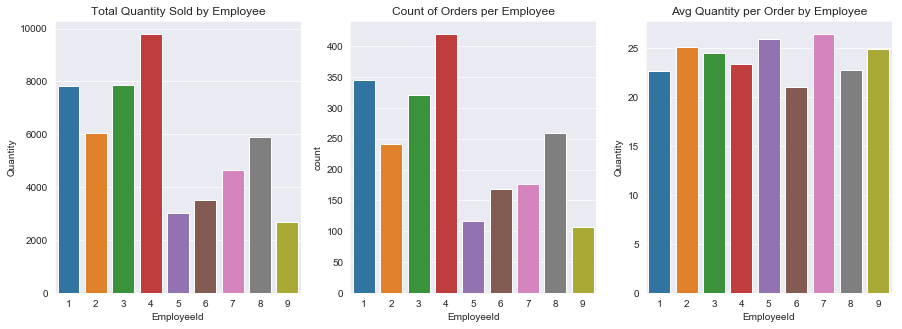

In [61]:
# set up plot are for three graphics
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

# create a bar plot of total quantity sold by employee in axis 1 
a = sns.barplot(x=df2_pivot.index, y=df2_pivot['sum']['Quantity'], ax=ax1)
a.axes.set_title('Total Quantity Sold by Employee')

# create a count plot of total number of orders per employee in axis 2
b = sns.countplot(x='EmployeeId', data=df2, ax=ax2)
b.axes.set_title('Count of Orders per Employee')

# crate a bar plot of the average quantity sold per employee in axis 3
c = sns.barplot(x=df2_pivot.index, y=df2_pivot['mean']['Quantity'], ax=ax3)
c.axes.set_title('Avg Quantity per Order by Employee');

**Observations:** 
* Very interestingly total quantity ordered and number of orders are very similar
* In naturally follows that that average order size is very similar as well 

#### Statistical test

To check and see if there is a statistically significant amount of variability between quantity per order per employee we can do an ANOVA test. For this test:
1. Our **null hypothesis (H0)** will be that there is no difference is order sizes for each employee
2. Our **alternative hypothesis (Ha)** will then be that there is some variance in quantity ordered per employee per order
3. We will look for a p-value that gives us a 95% confidence level of avoiding a type 1 error, and therefor set **alpha to .05**

In [62]:
# create formula with a target variable 'Quantity' and comparison variable
# 'EmployeeId' is a categorical variable so we will place it in parentheses with 'C'
formula = 'Quantity ~ C(EmployeeId)'

# fit the formula to a line using ordinary least squares and pass in the df2 data
lm = ols(formula, df2).fit()

# create an ANOVA table and observe
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),4643.183282,8.0,1.607646,0.11745
Residual,774756.452913,2146.0,NaN,NaN


**Question 2 Conclusion:** With a p-value above our level of alpha (0.117 > .05) we **fail to reject** the null hypothesis. We cannot conclude at this time that any employee sells a statistically significantly different quantity of items per sale. 

**Next Steps:** We now know from question 1 that discounts do tend to result in a larger quantity sold per order with significant effect, and we now know that while some employees do sell a much larger overall quantity, they all sell about the same quantity per order itself. 

A question that follows is: "Why do some employees sell more than others?" 

One hypothesis is that some employees may be more likely to use a discount than others. We'll explore that in our next question. 

## Question 3 

**Research question 3:** Do different employees use discounts at a rate that is statistically significantly different than the overall average rate of discount use? If so, which employees are more likely to employ a discount? Do those employees sell a larger overall quantity? 


#### Test employee discount use (ANOVA)
To start, let's do a quick ANOVA just to see if different employees have different relationships with the 'Discount' variable. For this test our hypotheses will be: 

**Null Hypothesis (H0): There is no significant difference in the relationship between discount and employee**

**Alternative Hypothesis (Ha): The is some statistically significant difference in the relationship between different employees and discount**

We'll set our confidence level at 95%, so we set alpha = .05 and will look for a p-value below that to consider rejecting H0

In [63]:
# set a formula with the discount as the target variable and EmployeeId as a categorical
formula = 'Discount ~ C(EmployeeId)'

# create a model with the formula and data frame
lm = ols(formula, df2).fit()

# create an ANOVA table
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),0.16041,8.0,2.899611,0.003232
Residual,14.83993,2146.0,NaN,NaN


**Conclusions:** For now it appears that with p = .0032 < alpha we can **reject H0** and claim that there is some difference between different employees and discount. 

We'll need to research this much further see precisely which employees and how much. 

To begin, it will help to make a simple variable that shows whether or not a discount was used in a sale. Then we can get the overall average rate of discount usage and compare that rate with each employee's actual use. 

#### Create dummy variable

In [64]:
# Create a new column called y_discount where the value is 1
# if Discount is greater than 0.0 and 0 if not
df2['y_discount'] = np.where(df2['Discount'] > 0.0, 1, 0)
df2.head()

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,EmployeeId,y_discount
0,10248/11,10248,11,14.0,12,0.0,5,0
1,10248/42,10248,42,9.8,10,0.0,5,0
2,10248/72,10248,72,34.8,5,0.0,5,0
3,10249/14,10249,14,18.6,9,0.0,6,0
4,10249/51,10249,51,42.4,40,0.0,6,0


Let's do another quick ANOVA to see if our first conclusion still holds, this time comparing EmployeeId to our new y_discount variable. For this test our hypotheses will be: 

**H0: There is no significant effect of employee on discount usage (y_discount)**

**Ha: There is some effect on discount use for different employees** 

We'll set our confidence level at 95%, so we set **alpha = .05** and will look for a p-value below that to consider rejecting H0

#### Test employee discount use again (ANOVA)

In [65]:
# set a formula with the discount as the target variable and EmployeeId as a categorical
formula = 'y_discount ~ C(EmployeeId)'

# create a model with the formula and data frame
lm = ols(formula, df2).fit()

# create an anova table
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),6.241641,8.0,3.309646,0.000914
Residual,505.891073,2146.0,NaN,NaN


Our p-value is now even lower than before (.0009 < alpha), so we can again **reject H0** and claim that some employees do use discounts at a statistically significant different rate than others. 

Let's now proceed with sampling all sales to determine what the overall average rate of discount use is, and then we can move forward with determining which employees use discounts differently. We'll use the same bootstrap method of sampling as before. 

#### Sample data

p = 4.5438235396488835e-09 	 Therefore the data is not normal


/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


False

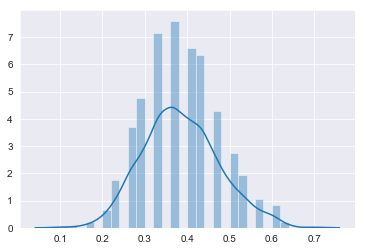

In [98]:
# create a random sample discount use for all sales
pop_sample = random_sample(df2.y_discount, 1000)

# make a distribution plot of the sample
sns.distplot(pop_sample)

# use shapiro-wilkes test to determine normality of sample
test_normality(pop_sample)

By relying on resampling and the central limit theorem we have created a normal distribution of sample means of discount usage. We can take the mean of this data as a good approximation of the population mean of discounts used in all sales and compare each employee's discount use to that mean. 

In [113]:
# derive the mean of sample means
xu = mean(pop_sample)
# determine the standard deviation of the population sample
std = np.std(pop_sample)
xu, std

(0.38489999999999996, 0.08972668994724417)

We have a population mean of .39, with a standard deviation of .095. We can reasonably claim that discounts are used in about 39.1% of sales. 

#### Employee data analysis

Before we move into deeper statistical analysis let's take a look at the data for each of the 9 employees. First let's check and see what their average discount use is before sampling

In [92]:
# create a list of employees 1-9
employees = list(range(1,10))

# create a dictionary with each employee as key, and a sample of thier discount
# use as a variable
discount_usage = {}
for e in employees:
    discount_usage[e] = round(df2[df2['EmployeeId'] == e]['y_discount'].mean()*100, 2)
    print(f'Employee {e} uses a discount {discount_usage[e]}% of the time.')

Employee 1 uses a discount 39.13% of the time.
Employee 2 uses a discount 31.54% of the time.
Employee 3 uses a discount 32.4% of the time.
Employee 4 uses a discount 40.48% of the time.
Employee 5 uses a discount 50.43% of the time.
Employee 6 uses a discount 41.07% of the time.
Employee 7 uses a discount 47.73% of the time.
Employee 8 uses a discount 36.15% of the time.
Employee 9 uses a discount 43.93% of the time.


There is a good range of discount use among our employees, with 31.5% on the low end, and 50.4% on the high end. Let's see how that looks visually. 

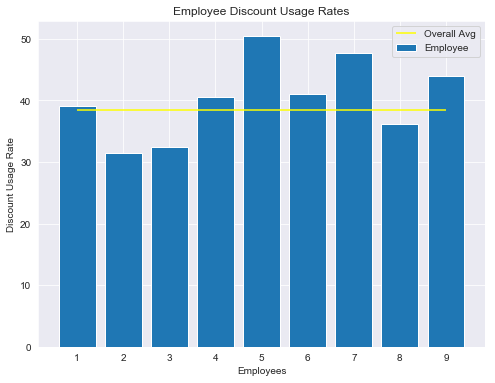

In [114]:
# plot average employee discount use rates and compare with the overall average
plt.figure(figsize=(8,6))
plt.bar(x=employees, height=discount_usage.values(), label='Employee')
plt.hlines(y=xu*100, xmin=1, xmax=9, label='Overall Avg', colors='yellow')
plt.xticks(ticks=employees)
plt.xlabel('Employees')
plt.ylabel('Discount Usage Rate')
plt.title('Employee Discount Usage Rates')
plt.legend();

**Observations:**
* Employees 5, 7, and 9 appear to use discounts the most frequently 
* Employees 2 and 3 use them the least

To test the significance of these differences we can sample each of our employee's sales and compare them to the population sample mean. We'll use the same sampling method as before, but let's got for a much larger sample this time. 

#### Create employee samples and test for normality and variance with the population sample

In [109]:
emp_samples = {}
for e in employees:
    emp_samples[e] = random_sample(df2[df2['EmployeeId'] == e]['y_discount'], 1000)

for k in emp_samples:
    print(f'Employee {k}: {test_normality(emp_samples[k])}')
    print(f'Employee {k}: {test_variance(pop_sample, emp_samples[k])}\n')

p = 1.1424764068124205e-07 	 Therefore the data is not normal
Employee 1: False
p = 0.54243587629567 	 Therefore the data has equal variances
Employee 1: True

p = 7.57597806710919e-09 	 Therefore the data is not normal
Employee 2: False
p = 0.051415380960212614 	 Therefore the data has equal variances
Employee 2: True

p = 9.107910869943225e-09 	 Therefore the data is not normal
Employee 3: False
p = 0.2558101335229554 	 Therefore the data has equal variances
Employee 3: True

p = 7.454153916341966e-08 	 Therefore the data is not normal
Employee 4: False
p = 0.9149146048034325 	 Therefore the data has equal variances
Employee 4: True

p = 1.439910164435787e-07 	 Therefore the data is not normal
Employee 5: False
p = 0.6829983754510409 	 Therefore the data has equal variances
Employee 5: True

p = 5.1608235906996924e-08 	 Therefore the data is not normal
Employee 6: False
p = 0.15871128834843037 	 Therefore the data has equal variances
Employee 6: True

p = 5.62549429261594e-09 	 There

**Observations:** We see that the most of our employee samples are not distributed normally based on the shapiro-wilkes test, but that all have an equal variance with the population sample. Despite the lack of normality we may still be able to use a t-test due to it's ability to tolerate some deviation from normality.

Let's take a look at our distributions visually before moving on to a statistical test. 

In [110]:
# create a data frame of our samples to iterate through. 
emp_discount_sample_df = pd.DataFrame.from_dict(emp_samples)
emp_discount_sample_df.head()

,1,2,3,4,5,6,7,8,9
0,0.466667,0.433333,0.500000,0.366667,0.433333,0.366667,0.400000,0.500000,0.433333
1,0.333333,0.233333,0.300000,0.366667,0.600000,0.533333,0.600000,0.333333,0.466667
2,0.333333,0.233333,0.400000,0.500000,0.600000,0.400000,0.433333,0.400000,0.333333
3,0.200000,0.366667,0.300000,0.366667,0.466667,0.400000,0.466667,0.466667,0.366667
4,0.433333,0.166667,0.333333,0.300000,0.500000,0.366667,0.400000,0.333333,0.466667


In [104]:
# create a funtioan that will take a data frame and return a group of distribution
def get_distplots(df, comparison, cols=1):
    rows = math.ceil(len(df.columns)/cols)
    figwidth = 5 * cols
    figheight = 4 * rows
    
    fig, ax = plt.subplots(nrows = rows,
                           ncols = cols,
                           figsize = (figwidth, figheight))
    
    ax = ax.ravel()
    
    for i, column in enumerate(df.columns):
        sns.distplot(df[column], ax=ax[i], label='Emp Sample')
        sns.distplot(comparison, ax=ax[i], label='Pop Sample')
        
    
    plt.legend()
    plt.show()

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


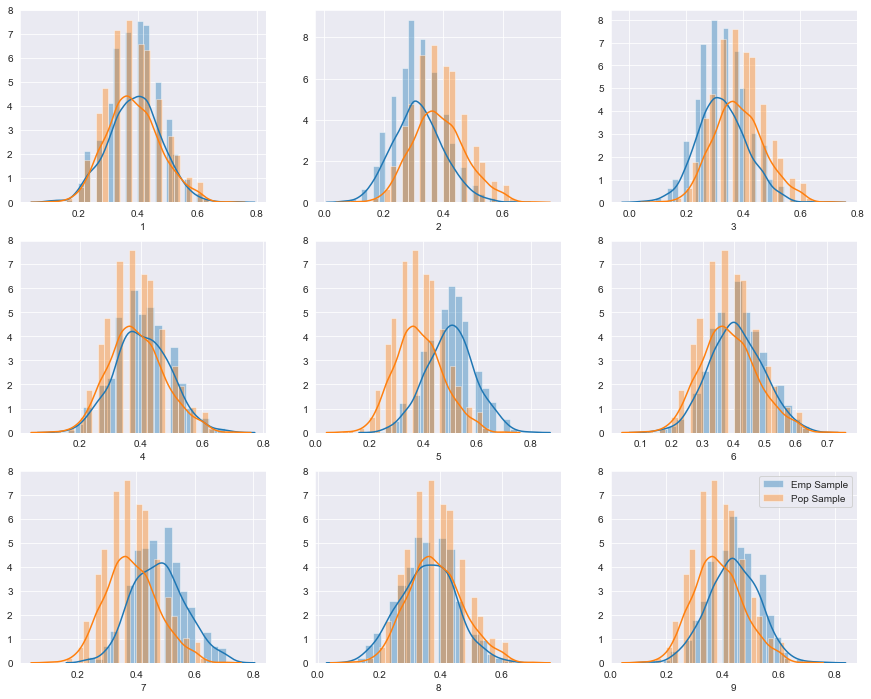

In [111]:
get_distplots(emp_discount_sample_df, pop_sample, cols=3)

**Observations:**
* Similar to what we've see previously, employees 5 and 7 seem to be to the right of the population sample
* Employees 2 and 3 appear to be to the left. 
* Employee 9 may also be above the population mean. 

#### Statistical Analysis - 1-sample t-test

At this time we have enough time to state hypotheses and conduct our tests. We'll state the same hypotheses for each employee **X**:

**H0: The difference in the rate that Employee X uses a discount is not statistically significant from the overall rate of discount use.**

**Ha: The difference in the rate that Employee X uses a discount IS statistically significant from the overall rate of discount use. Employee X is more or less likely to use a discount than the average.**

Because we are conducting multiple comparisons we will use the **Bonferroni Correction** to establish alpha for our 95% confidence level. 

Since we are comparing an employee sample to the population sample mean we'll use a one sample t-test. 

In [115]:
# establish alpha with the bonferroni correction
employee_bonferroni = round(bonferroni_alpha(obs=9),4)

# run t-tests for each employee sample and return a list of employees that use 
# discounts differntly than the population average
discount_employees = []
for k in emp_samples:
    p = stats.ttest_1samp(emp_samples[k], xu)[1]
    results = check_null_hypothesis(p, alpha=employee_bonferroni)
    print(f'Employee {k}: {results}\n')
    if results == False:
        discount_employees.append(k)
print(f'Employees {discount_employees} use discounts at a statistically diffent rate than the sample mean xu = {xu}')

With a p-value of 0.0961314650052162, which is greater than 0.0056, at this time we fail to reject the H0
Employee 1: True

With a p-value of 3.397706115056494e-113, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 2: False

With a p-value of 1.571759792183275e-82, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 3: False

With a p-value of 1.3959408003178319e-12, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 4: False

With a p-value of 2.643806943159211e-215, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 5: False

With a p-value of 7.585401178406437e-17, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 6: False

With a p-value of 1.0840888629164416e-157, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 7: False

With a p-value of 1.0268627184862945e-19, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 8: False

With a p-value of 1.521

**Observations:**
* It appears that **nearly all** of our employees (except employee 1) use discounts at a rate this is different than the overall average
* **However** we are not yet ready to accept or reject **H0** - based on observations above many employees looked very close to the overall population - do be sure we should check effect sizes. 

#### Check effect sizes

In [116]:
# calculate effect sizes of each result and add to a dictionary
emp_discount_effects = {}
for e in discount_employees:
    emp_discount_effects[e] = cohen_d(emp_samples[e], pop_sample)
emp_discount_effects

{2: 0.7930409088630236,
 3: 0.6604673571667329,
 4: 0.22720093654847412,
 5: 1.293940574709008,
 6: 0.26320068084720977,
 7: 1.0293169093696253,
 8: 0.2946452102311732,
 9: 0.5994746479863635}

In [118]:
# determine which effects are large, medium, or small
for e in emp_discount_effects:
    if emp_discount_effects[e] > .8:
        print (f'Employee {e} has a LARGE effect with {emp_discount_effects[e]}')
    elif emp_discount_effects[e] > .5:
        print (f'Employee {e} has a MEDIUM effect with {emp_discount_effects[e]}')
    else:
        print(f'Employee {e} has a SMALL effect with {emp_discount_effects[e]}')

Employee 2 has a MEDIUM effect with 0.7930409088630236
Employee 3 has a MEDIUM effect with 0.6604673571667329
Employee 4 has a SMALL effect with 0.22720093654847412
Employee 5 has a LARGE effect with 1.293940574709008
Employee 6 has a SMALL effect with 0.26320068084720977
Employee 7 has a LARGE effect with 1.0293169093696253
Employee 8 has a SMALL effect with 0.2946452102311732
Employee 9 has a MEDIUM effect with 0.5994746479863635


**Observations:** 
* As suspected earlier, employees 5 and 7 have sufficiently large effects to draw a conclusion
* Employees 2, 3, and 9 have medium effects, and the remainder are small

Before stating our final conclusions let's check power to make sure we've considered a sufficiently large set of data (with 1000 samples this is very likely to be the case). 

In [123]:
# check the power for each effect size. 
discount_powers = {}
for e in emp_discount_effects:
    discount_powers[e] = power.solve_power(effect_size=e, 
                                           nobs1=len(emp_discount_sample_df), 
                                           alpha=employee_bonferroni)
discount_powers

{2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}

**Observations:** It's no surprise that we can see we have very high statistical power, we've taken a large set of samples to compare

* For **employees 5 and 7** at this time we can **reject Ho and accept Ha** and claim that they use discounts at a rate that is large and statistically significantly different than the overall average

* For all others we fail to see a large enough effect at this time and **fail to reject H0** 


Let's answer the final part of our question which was, do those employees that use discounts sell greater amounts overall? 

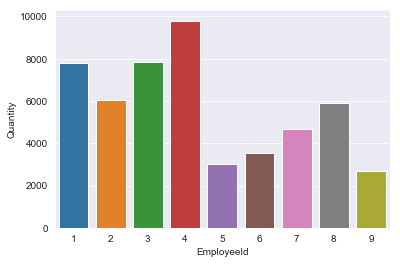

In [129]:
# show a bar plot of quantity sold by employee
sns.barplot(x=df2_pivot.index, y=df2_pivot['sum']['Quantity'])

**Observations:** 
* NO, it turns out that employees 5 and 7 are in fact in the bottom half of employees when ranked by total quantity sold. 
* In fact, employees 2 and 3, who seems less likely to use a discount are in the upper half of sales by quantity

#### Question 3 Conclusions:

1. While we can safely claim that discounts have a large and positive statistically significant effect on quantity of product ordered, it turns out that the employees that use them the most actually sell less overall. 
2. This is an interesting conclusion considering that all employees generally sell similar quantities per order - it could mean that these employees have weaker sales performance overall, and that they have difficulty making sales in general and must use discounts to close deals
3. We should look further into the potential consequences of this performance and it's effects on revenue

## Question 4 

As a final question let's see what the effect of discount use has on revenue. Discounts obviously reduce revenue, but how much matters, and it matters if some of our employees are using discounts that reduce revenue below the revenue that would be gained from a smaller sale at a non-discounted price. Aside from very specific sales and marketing strategies, increased quantity sold is not beneficial if it does not also result in increase revenue (and profit)  

**Research Question:** Does discount have a statistically significant and positive effect on revenue? If so, at which rates? 

#### Gathering data

We can continue to use the date we've been using for our previous analysis, but we will need to derive revenue figures per sale. 

In [130]:
# create a new dataframe to work with in this question
df3 = df2
df3.head()

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,EmployeeId,y_discount
0,10248/11,10248,11,14.0,12,0.0,5,0
1,10248/42,10248,42,9.8,10,0.0,5,0
2,10248/72,10248,72,34.8,5,0.0,5,0
3,10249/14,10249,14,18.6,9,0.0,6,0
4,10249/51,10249,51,42.4,40,0.0,6,0


In [131]:
# create a new column of data 'Expected_Revenue' by multiplying unit price and quantity sold
df3['Expected_Revenue'] = df3['UnitPrice'] * df3['Quantity'] 
# create a new column of data 'DiscountCost' by multiplying the expected revenue by the size of the discount
df3['DiscountCost'] = df3['Expected_Revenue'] * df3['Discount']
# create a new column of data 'Actual_Revenue' by subtracting discount cost from expected revenue
df3['Actual_Revenue'] = df3['Expected_Revenue'] - df3['DiscountCost']

In [132]:
# check the data frame, info, and central tendencies
inspect_dataframe(df3)

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,EmployeeId,y_discount,Expected_Revenue,DiscountCost,Actual_Revenue
0,10248/11,10248,11,14.0,12,0.0,5,0,168.0,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,5,0,98.0,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,5,0,174.0,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,6,0,167.4,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,6,0,1696.0,0.0,1696.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 11 columns):
Id_x                2155 non-null object
OrderId             2155 non-null int64
ProductId           2155 non-null int64
UnitPrice           2155 non-null float64
Quantity            2155 non-null int64
Discount            2155 non-null float64
EmployeeId          2155 non-null int64
y_discount          2155 non-null int64
Expected_Revenue    2155 non-null float64
DiscountCost        2155 non-null float64
Actual_Revenue      2155 non-null float64
dtypes: float64(5), int64(5), object(1)
memory usage: 282.0+ KB


None

,OrderId,ProductId,UnitPrice,Quantity,Discount,EmployeeId,y_discount,Expected_Revenue,DiscountCost,Actual_Revenue
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,4.333179,0.388863,628.519067,41.144107,587.374960
std,241.378032,22.159019,29.827418,19.022047,0.083450,2.490351,0.487605,1036.466980,133.993817,969.224235
min,10248.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.800000,0.000000,4.800000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,2.000000,0.000000,154.000000,0.000000,147.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,4.000000,0.000000,360.000000,0.000000,337.750000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,7.000000,1.000000,722.250000,30.560000,656.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,9.000000,1.000000,15810.000000,2108.000000,15810.000000


In [133]:
# split data into two groups based on discount and compare
full_cost_sales = df3[df3['y_discount'] == 0]['Actual_Revenue']
discount_sales = df3[df3['y_discount'] == 1]['Actual_Revenue']

compare_2(full_cost_sales, discount_sales)

The size of group1 is: 1317  	  The size of group2 is 838
The mean of group1 is: 570.0065375854214 	  The mean of group2 is: 614.671156921241
The std of group1 is: 961.3750303140845 	  The std of group2 is: 981.3883857404984


**Observations:**
* There appear to be a number of very large sales that skew the data
* The mean revenue size per sale is otherwise relatively close

Let's see how they look visually

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


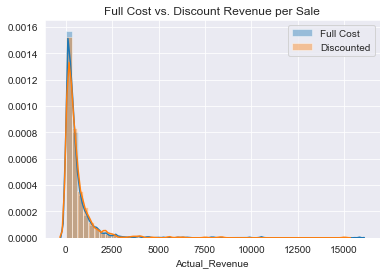

In [135]:
# Plot the distributions of both groups
sns.distplot(full_cost_sales, label='Full Cost')
sns.distplot(discount_sales, label='Discounted')
plt.title('Full Cost vs. Discount Revenue per Sale')
plt.legend()

We can see that those outliers are significantly skewing our distribution, but let's do a quick shapiro-wilkes test anyway.

In [136]:
# check normality with shapiro, wilkes
test_normality(full_cost_sales), test_normality(discount_sales)

p = 0.0 	 Therefore the data is not normal
p = 1.3032075718220799e-43 	 Therefore the data is not normal


(False, False)

**Drop Outliers:** Let's drop values above $2500 to see if we can get a more workable set of data. 

In [137]:
# create a version of our dataframe that only has revenue less than or equal to 2500
df3 = df3[df3['Actual_Revenue'] <= 2500]
df3.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,EmployeeId,y_discount,Expected_Revenue,DiscountCost,Actual_Revenue
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,10658.499524,40.857143,23.664733,22.871905,0.056114,4.331429,0.388571,504.610929,32.848053,471.762876
std,241.601506,22.304288,21.196577,17.625971,0.083290,2.488212,0.487542,500.134327,73.748546,464.836586
min,10248.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.800000,0.000000,4.800000
25%,10449.000000,21.000000,12.000000,10.000000,0.000000,2.000000,0.000000,150.000000,0.000000,144.000000
50%,10657.000000,41.000000,18.000000,20.000000,0.000000,4.000000,0.000000,349.000000,0.000000,323.000000
75%,10861.000000,60.000000,31.050000,30.000000,0.100000,7.000000,1.000000,667.200000,29.580000,616.700000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,9.000000,1.000000,3080.000000,618.950000,2475.800000


/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


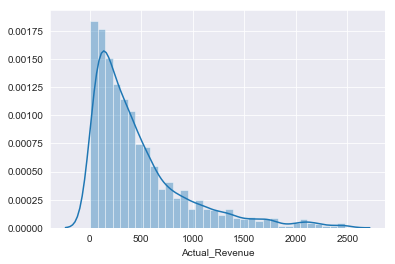

In [138]:
sns.distplot(df3.Actual_Revenue)

We've dropped 55 sales and have a slightly better distribution. It's still very skewed, but by sampling we can likely reduce that effect.

Let's compare again.

In [139]:
# create two groups based on discount and compare
full_cost_sales = df3[df3['y_discount'] == 0]['Actual_Revenue']
discount_sales = df3[df3['y_discount'] == 1]['Actual_Revenue']

compare_2(full_cost_sales, discount_sales)

The size of group1 is: 1284  	  The size of group2 is 816
The mean of group1 is: 457.02450934579434 	  The mean of group2 is: 494.95412928921564
The std of group1 is: 453.1438289746369 	  The std of group2 is: 482.031987623719


**Observations:** 
* The size of both groups is still sufficiently large enough for analysis
* The means of both groups have become closer

In [140]:
# Check normality with shapiro-wilkes
test_normality(full_cost_sales), test_normality(discount_sales)

p = 2.1221477389517116e-36 	 Therefore the data is not normal
p = 1.9628763524945976e-29 	 Therefore the data is not normal


(False, False)

#### Sample
The data is still not normal, so we can sample to see if we can increase normality. We'll use the same sampling method as above.

In [145]:
# create two random samples with replacement
full_cost_sample = random_sample(full_cost_sales, size=100)
discount_rev_sample = random_sample(discount_sales, size=100)

# test for normality with shapiro-wilkes 
test_normality(full_cost_sample), test_normality(discount_rev_sample)

p = 0.9067633152008057 	 Therefore the data is normal
p = 0.46802377700805664 	 Therefore the data is normal


(True, True)

In [195]:
# get the size, mean and standard error of both samples
compare_2(np.array(full_cost_sample), np.array(discount_rev_sample))

The size of group1 is: 100  	  The size of group2 is 100
The mean of group1 is: 452.9883933333333 	  The mean of group2 is: 494.66083750000007
The std of group1 is: 74.37433169624495 	  The std of group2 is: 88.22346809859715


Let's inspect our distributions visually.

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Full Cost vs. Discount Samples')

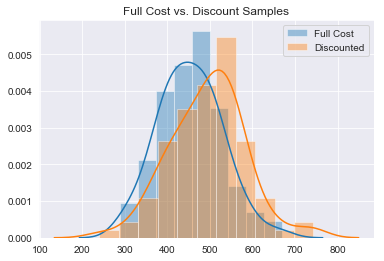

In [146]:
# plot two distribution plots and compare
sns.distplot(full_cost_sample, label='Full Cost')
sns.distplot(discount_rev_sample, label='Discounted')
plt.legend()
plt.title('Full Cost vs. Discount Samples')

In [147]:
# compare variance with Levene's test
test_variance(full_cost_sample, discount_rev_sample)

p = 0.24261886045061107 	 Therefore the data has equal variances


True

#### Statistical Test 

We've seen that we have normally distributed data with equal variance, therefore we can do a conduct a t-test to see if there is a significant effect of discount on actual revenue. We have to remember that we are only considering sales at or below 2500, and we're looking for an increase in revenue, so we'll state our hypotheses as: 

**H0: Discount has no statistically significant effect on revenue for sales below 2500** 

**Ha: Discount has a statistically significant and positive effect on revenue for sales over 2500**

We'll aim for a confidence level of 95%, so we will set **alpha = .05** and look for a p-value below that if we would like to reject the null hypothesis. 

In [198]:
# conduct an t-test with two independent samples (full cost and discount) with equal varance
p = stats.ttest_ind(full_cost_sample, discount_rev_sample, equal_var=True)[1]
check_null_hypothesis(p)

With a p-value of 0.000411973377364855, which is less than 0.05 we can reject the H0 and accept Ha


False

Our p-value is below the threshold we set for alpha, which may mean that we can reject H0, but before we do so we should check our effect size to get an idea of how much discounts actually raise revenue. 

#### Check effect of discount on revenue

In [199]:
# Derive cohen's d to determint effect size
revenue_effect = cohen_d(full_cost_sample, discount_rev_sample)
revenue_effect

0.510733876808748

**Observations:** An effect of **.51** falls just within the medium range of effect size. This means that the mean of our sample group is **only roughly .5 standard errors away from the control mean, and that there is roughly 80% overlap in the two samples.** This does not give a lot of confidence in our ability to reject H0. 

Before we make a final conclusion let's look at power. 

#### Check power

In [201]:
# enter effect, number of observations, and alpha to determine power
power.solve_power(effect_size=revenue_effect, nobs1=len(discount_rev_sample), alpha=.05)

0.9488598981230547

With a large result for power **(.95)** we can conclude that we have seen enough data to make a conclusion. 

#### Q4 Part 1 Conclusion
At this time we can answer the first part of our question - **does discount have a statistically significant and positive effect on revenue?**

With a very low p-value we can **potentially reject H0** and claim that discount does have a statistically significant effect on revenue. However, we also have a **medium to small effect size**. So at this time we will reserve judgment and suggest further analysis. 

Let's answer the second part of our, question. What discount sizes have a significant effect. 

#### Q4 Part 2

To make an initial assessment as to whether or not other factors play effect revenue, we can conduct an ANOVA with both EmployeeId and Discount to see if there is any variability in their relationship with total discount. 

#### Statistical Test - ANOVA

For this ANOVA our hypotheses will be:

**H01: Different Employees have no statistically significant effect on Actual Revenue**
**H02: Different Discount rates have no statistically significant effect on Actual Revenue**

**Ha1: There is a statistically significant variance between different Employees and Actual Revenue**
**Ha2: There is a statistically significant variance between different Employees and Actual Revenue**

For this analysis we will seek 95% confidence and set **alpha = .05**

In [203]:
# create a formula with 'Actual_Revenue' as the target variable and 
# EmployeeId and Discount as categorical independent variables
formula = 'Actual_Revenue ~ C(EmployeeId) + C(Discount)'

# create a model our formual and data
lm = ols(formula, df3).fit()

# create an ANOVA table
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),1.452500e+06,8.0,0.842893,0.564714
C(Discount),4.006124e+06,10.0,1.859819,0.046349
Residual,4.482558e+08,2081.0,NaN,NaN


**Observations:** 
* With a p-value of .56 we **fail to reject H01** and conclude that there is no significant variance between Actual Revenue for employees
* With a p-value of .046 we can **reject H02** and **accept Ha2** and claim significant variance between discount values. However, with a p-value **.046 we are very close to alpha** We still have a reasonable chance of type-1 error. 

Let's look further at discount rates. We know from our previous analysis that only the 5%, 10%, 15%, 20% and 25% rates have a significant effect on quantity ordered, so we only consider those for our next round of analysis. 

We can create new samples with each rate and check assumptions as before. 

In [179]:
# create a random sample using the bootstrap method for each level of discount
five_rev_sample = random_sample(df3[df3['Discount'] == .05]['Actual_Revenue'], size=100)
ten_rev_sample = random_sample(df3[df3['Discount'] == .1]['Actual_Revenue'], size=100)
fifteen_rev_sample = random_sample(df3[df3['Discount'] == .15]['Actual_Revenue'], size=100)
twenty_rev_sample = random_sample(df3[df3['Discount'] == .2]['Actual_Revenue'], size=100)
twentyfive_rev_sample = random_sample(df3[df3['Discount'] == .25]['Actual_Revenue'], size=100)

# create a dictionary of samples to iterate through for easier analysis
revenue_samples = {'5% Discount':five_rev_sample, 
                    '10% Discount':ten_rev_sample, 
                    '15% Discount':fifteen_rev_sample, 
                    '20% Discount':twenty_rev_sample, 
                    '25% Discount':twentyfive_rev_sample}

# test the normality and compare variance for each discount sample and print results
for s in revenue_samples:
    print(f'{s}: {test_normality(revenue_samples[s])}')
    print(f'{s}: {test_variance(revenue_samples[s], full_cost_sample)}\n')

p = 0.1542452573776245 	 Therefore the data is normal
5% Discount: True
p = 0.1346694246261717 	 Therefore the data has equal variances
5% Discount: True

p = 0.649016797542572 	 Therefore the data is normal
10% Discount: True
p = 0.051123969390003396 	 Therefore the data has equal variances
10% Discount: True

p = 0.4773898422718048 	 Therefore the data is normal
15% Discount: True
p = 0.05498102570609783 	 Therefore the data has equal variances
15% Discount: True

p = 0.4168056845664978 	 Therefore the data is normal
20% Discount: True
p = 0.636604530005191 	 Therefore the data has equal variances
20% Discount: True

p = 0.7772917151451111 	 Therefore the data is normal
25% Discount: True
p = 0.6528580513300175 	 Therefore the data has equal variances
25% Discount: True



**Observations:**
* Our samples are all normal and have equal variance with our control (non-discount) sample
* We will be doing multiple comparisons, so it is therefor appropriate to apply the Bonferroni Correction

In [185]:
# set a new level of alpha by applying the Bonferroni correction
# enter the number of observations and original level of alpha
b_alpha = bonferroni_alpha(obs=5, alpha=alpha)
b_alpha

0.01

#### Statistical Test
We'll conduct an independent t-test with two samples for each discount sample. Our hypotheses will be: 

**H0: Discount rate X has no statistically significant effect on actual revenue** 

**Ha: Discount rate X has a statistically significant and positive effect on actual revenue**

We'll use our corrected value for **alpha - .01**

In [204]:
# find p-value and conduct a t-test with two independent samples and equal variance for each sample
# and add any rejections to a list for further analysis
revenue_rates = []
for s in revenue_samples:
    p = stats.ttest_ind(full_cost_sample, revenue_samples[s], axis=0, equal_var=True)[1]
    results = check_null_hypothesis(p, alpha=b_alpha)
    print(f'{s}: {results}\n')
    if results == False:
        revenue_rates.append(s)
print(f'The {revenue_rates} rates appear to have a statistically significant effect on revenue.')

With a p-value of 1.0412959401391016e-18, which is less than 0.01 we can reject the H0 and accept Ha
5% Discount: False

With a p-value of 0.0007715624537032279, which is less than 0.01 we can reject the H0 and accept Ha
10% Discount: False

With a p-value of 4.700094273719026e-06, which is less than 0.01 we can reject the H0 and accept Ha
15% Discount: False

With a p-value of 0.47314379470490864, which is greater than 0.01, at this time we fail to reject the H0
20% Discount: True

With a p-value of 0.4034502280055433, which is greater than 0.01, at this time we fail to reject the H0
25% Discount: True

The ['5% Discount', '10% Discount', '15% Discount'] rates appear to have a statistically significant effect on revenue.


**Observations:**
* At this time it appears we may be able to reject H0 for three discount rates - 5, 10, and 15%
    * we'll check effect size and power before we make a final conclusion
* We **fail to reject H0** the 20% and 25% rates - these rates do not have an effect on actual revenue

Let's visualize our distributions to see how they look before calculating effect. 

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


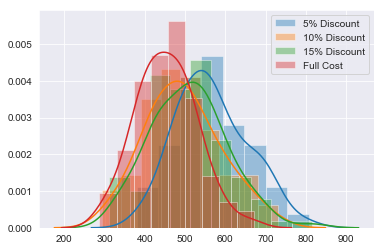

In [210]:
# plot distplots for all discount rates and compare to the non-discount group
for r in revenue_rates: 
    sns.distplot(revenue_samples[r], label=(f'{r}'))
    
sns.distplot(full_cost_sample, label='Full Cost')
plt.legend()

**Observations:**
* Based on the visual distance of the means it looks like 5% is the only rate with a large effect on revenue
* 10% is almost entirely covered by the Full Cost distribution and likely has a small effect

#### Calculate effect sizes

In [191]:
# calculate effect sizes of each result and add to a dictionary
revenue_effects = {}
for r in revenue_rates:
    revenue_effects[r] = cohen_d(revenue_samples[r], full_cost_sample)
revenue_effects

{'5% Discount': 1.3915222876818896,
 '10% Discount': 0.48550132640881466,
 '15% Discount': 0.66913616857407}

* **5%** is the only discount rate with a large effect.
* 10% is small and 15% is medium

#### Check statistical power

In [211]:
#  solve for power by entering effect size, number of observations, and
# bonferroni alpha for each
revenue_powers = {}
for e in revenue_effects:
    revenue_powers[e] = power.solve_power(effect_size=revenue_effects[e], 
                                          nobs1=len(revenue_samples[e]),
                                          alpha=b_alpha)
revenue_powers

{'5% Discount': 1.0,
 '10% Discount': 0.7962713854706021,
 '15% Discount': 0.9828218311505225}

#### Q4 Part 2 Conclusions
* Finally, with an extremely low p-value and large effect and power size, we can confidently **reject H0** at the 5% discount rate and **accept Ha**, claiming that it has a large and statistically significant effect on actual revenue - meaning that sales made with a 5% discount not only increase quantity sold, but also increase revenue gained

* We'll **reserve judgment and fail to reject H0 for the 10% and 15% rates** at this time. Although they were found to have sufficiently low p-values, their effect sizes and statistical power were not large enough to accept Ha, we suggest further research on the effect these rates have on sales. 

* The 20% and 25% samples were found to have no effect on revenue. However, earlier we did determine that they have large and significant effects on quantity. We'll discuss this more in the project conclusions. 

## Project Conclusions

At this point we've done a fairly thorough analysis of our questions and come to the following conclusions: 

1. Discount does appear to have a large statistically significant effect on quantity sold per order
    * We found this to be true for  the 5%, 10%, 15%, 20%, and 25% rates
    * The 25% rate had the largest effect, followed by 15% and 5% 

2. Although employees have sold a large range of total quantities, they all sell roughly the same quantity per order.

3. Employees 5 and 7 use discount rates at a large statistically significantly different rate than the overall average
    * This is particularly interesting because they also sell less total quantity than many other employees, despite discounts leading to greater quantities sold

4. Although discounts lead to greater quantity sold, they do not result in a large effect on revenue
    * There is a moderate effect on actual revenue
    * The 5% discount rate is the only one that significantly leads to increased revenue
      - This is important because we would hope that the larger sale by quantity would also result in an increase in revenue
      - The sale encourages customers to spend a greater amount
    * The 20% and 25% discount rates have no effect on revenue, but large effects on quantity
      - This is important because it is a significant discount, it should have positive effects 

### Next Steps and Recommendations

**Next Steps:**
* There is a great deal of research that needs to be done to determine greater effects of discount and discount use
* We should do research into whether or not discounts lead to greater return customers, or what amount of additional sales can be expected after giving a discount, and at which rates
    - As of now it appears that employees that use the largest discounts sell less overall, even though they may sell more per order. This could mean that overly generous deals are resulting in less return business
* Similarly, we should see what, if any, relationship there is between discount and marketing or inventory strategies, such customer acquisition, product bundling, and stock clearing strategies

**Recommendations:**
* As discussed previously, and **outlined below**, not all employees use discounts evenly
* Employees 5, 7, and 9 use high discount rates disproportionately to their peers, but also have lower total sales figures
   - This may be the result of a number of factors: they may be new and have had less time to accumulate total sales, they may be working to enter new markets, and they may have poor sales techniques and rely too heavily on large discounts to close deals
   - If the latter in the case, we recommend sales training and coaching from more seasoned employees
* As all sales rates result in larger quantity sold per order, but only the 5% rate results in greater revenue per order, we recommend capping large discretionary discounts for sales people 

In [238]:
# create a pivot table that counts discount instances by employee
dis_counts = df2.pivot_table(values='OrderId', 
                             index='EmployeeId', 
                             columns='Discount', 
                             aggfunc= np.count_nonzero,
                             margins=True,
                             fill_value=0)

# create a pivot table with the rates each employee uses each discount rate
dis_count2 = round(dis_counts.div(dis_counts.iloc[:,-1], axis=0 ), 2)
dis_count2

Discount,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25,All
EmployeeId,,,,,,,,,,,,
1,0.61,0.0,0.01,0.01,0.0,0.12,0.0,0.08,0.04,0.07,0.06,1.0
2,0.68,0.0,0.00,0.00,0.0,0.07,0.0,0.07,0.07,0.07,0.04,1.0
3,0.68,0.0,0.00,0.00,0.0,0.05,0.0,0.08,0.06,0.06,0.07,1.0
4,0.60,0.0,0.00,0.00,0.0,0.10,0.0,0.05,0.08,0.09,0.09,1.0
5,0.50,0.0,0.00,0.00,0.0,0.18,0.0,0.09,0.10,0.01,0.13,1.0
6,0.59,0.0,0.00,0.00,0.0,0.08,0.0,0.16,0.06,0.05,0.06,1.0
7,0.52,0.0,0.00,0.00,0.0,0.07,0.0,0.11,0.06,0.18,0.06,1.0
8,0.64,0.0,0.00,0.00,0.0,0.05,0.0,0.09,0.08,0.07,0.08,1.0
9,0.56,0.0,0.00,0.00,0.0,0.08,0.0,0.03,0.19,0.04,0.10,1.0


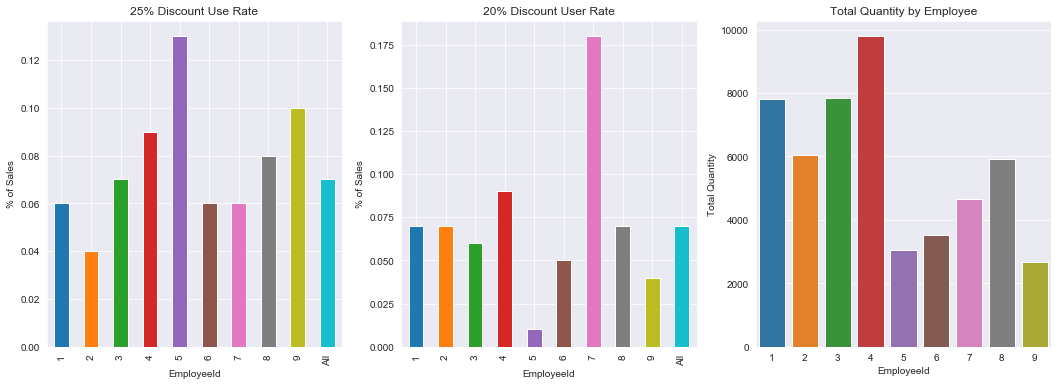

In [258]:
# set figure size and axes for two side-by-side plots
plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

# plot the 25% discount use rate
a = dis_count2[0.25].plot.bar(ax= ax1)
a.axes.set_title('25% Discount Use Rate')
a.axes.set_xlabel('EmployeeId')
a.axes.set_ylabel('% of Sales')

# plot the 20% discount rate
b = dis_count2[0.2].plot.bar(ax= ax2)
b.axes.set_title('20% Discount User Rate')
b.axes.set_xlabel('EmployeeId')
b.axes.set_ylabel('% of Sales')

# plot the quantity sold for each employee
c = sns.barplot(x=df2_pivot.index, y=df2_pivot['sum']['Quantity'], ax=ax3)
c.axes.set_title('Total Quantity by Employee')
c.axes.set_xlabel('EmployeeId')
c.axes.set_ylabel('Total Quantity')

plt.show()